In [1]:
import numpy as np 
import pandas as pd 
import os
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import Rescaling, RandomZoom, RandomFlip, RandomRotation
from sklearn.model_selection import train_test_split
import os
from distutils.dir_util import copy_tree, remove_tree
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

In [3]:
base_dir = "dataset2/"
root_dir = "./"
test_dir = base_dir + "test/"
train_dir = base_dir + "train/"
work_dir = root_dir + "dataset/"

if os.path.exists(work_dir):
    remove_tree(work_dir)
    

os.mkdir(work_dir)
copy_tree(train_dir, work_dir)
copy_tree(test_dir, work_dir)
print("Working Directory Contents:", os.listdir(work_dir))

WORK_DIR = './dataset/'


Working Directory Contents: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


In [4]:
os.listdir(WORK_DIR)


['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

In [5]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)
    
print(tf.__version__)

Number of replicas: 1
2.13.0


In [6]:
# Constants
IMG_SIZE = 176
IMAGE_SIZE = [176, 176]
DIM = (IMG_SIZE, IMG_SIZE)


In [7]:
# Create the data augmentation pipeline
data_augmentation = tf.keras.Sequential([
    Rescaling(1./255),
    RandomZoom(0.2),
    RandomFlip("horizontal"),
    RandomRotation(0.2)
])

In [8]:
# Load images and apply data augmentation
train_data_gen = tf.keras.preprocessing.image_dataset_from_directory(
    directory=WORK_DIR,
    image_size=DIM,
    batch_size=64,
    shuffle=False,
    seed=42,
    validation_split=None,
    subset=None,
    labels="inferred"
)

Found 6400 files belonging to 4 classes.


In [9]:
train_data_augmented = train_data_gen.map(lambda x, y: (data_augmentation(x, training=True), y))

In [10]:
train_data = []
train_labels = []

for data, labels in train_data_augmented:
    train_data.append(data)
    train_labels.append(labels)

train_data = tf.concat(train_data, axis=0)
train_labels = tf.concat(train_labels, axis=0)

In [11]:
# print(train_data)
print(train_labels)

tf.Tensor([0 0 0 ... 3 3 3], shape=(6400,), dtype=int32)


In [12]:
num_samples = train_data.shape[0]
train_data_2d = tf.reshape(train_data, (num_samples, -1))


In [13]:
print(train_data_2d)

tf.Tensor(
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.32502887 0.32502887 0.32502887 ... 0.53339463 0.53339463 0.53339463]
 [0.26156783 0.26156783 0.26156783 ... 0.0093731  0.0093731  0.0093731 ]
 ...
 [0.76373917 0.76373917 0.76373917 ... 0.5603532  0.5603532  0.5603532 ]
 [0.5240616  0.5240616  0.5240616  ... 0.52503836 0.52503836 0.52503836]
 [0.17518309 0.17518309 0.17518309 ... 0.16632201 0.16632201 0.16632201]], shape=(6400, 92928), dtype=float32)


In [14]:
#  perform over-sampling using the Synthetic Minority Over-sampling Technique for Image Data (SMOTE-IMG)
smote_img = SMOTE(sampling_strategy='minority')

In [15]:
train_data_resampled, train_labels_resampled = smote_img.fit_resample(train_data_2d, train_labels)
# Reshape train_data_resampled back to 4D  //4D -> Batch Size , Height , Width , Color Channels
train_data_resampled = train_data_resampled.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

In [64]:
print(train_data_resampled)
train_data_resampled.shape

[[[[3.26963793e-03 3.26963793e-03 3.26963793e-03]
   [3.13549157e-04 3.13549157e-04 3.13549157e-04]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]
   ...
   [7.08177919e-03 7.08177919e-03 7.08177919e-03]
   [2.35187635e-03 2.35187635e-03 2.35187635e-03]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]]

  [[4.26604412e-03 4.26604412e-03 4.26604412e-03]
   [1.80071278e-04 1.80071278e-04 1.80071278e-04]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]
   ...
   [2.58336263e-03 2.58336263e-03 2.58336263e-03]
   [9.43016494e-04 9.43016494e-04 9.43016494e-04]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]]

  [[4.98797512e-03 4.98797512e-03 4.98797512e-03]
   [5.02268260e-04 5.02268260e-04 5.02268260e-04]
   [2.07132951e-04 2.07132951e-04 2.07132951e-04]
   ...
   [6.77421049e-04 6.77421049e-04 6.77421049e-04]
   [8.91508025e-05 8.91508025e-05 8.91508025e-05]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]]

  ...

  [[0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [1.35093986e-

(9536, 176, 176, 3)

In [16]:
# Split the augmented data into train and test sets
train_data1, test_data1, train_labels1, test_labels1 = train_test_split(train_data_resampled, train_labels_resampled, test_size=0.2, random_state=42,stratify=train_labels_resampled)
# Further split the train set into train and validation sets
train_data1, val_data1, train_labels1, val_labels1 = train_test_split(train_data1, train_labels1, test_size=0.2, random_state=42,stratify=train_labels1)

## --> Stratify == preserves the class distribution in the train and test split

In [17]:
from keras.utils import to_categorical

train_labels1 = to_categorical(train_labels1)
val_labels1 = to_categorical(val_labels1)

In [18]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block



In [19]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block



In [20]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0],IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(4,activation='softmax')
    ])
    
    return model



In [21]:
with strategy.scope():
    model = build_model()

    METRICS = [tf.keras.metrics.AUC(name='auc')]
    
    model.compile(
        optimizer='adam',
        loss=tf.losses.CategoricalCrossentropy()
        ,
        metrics=METRICS
    )
    
    
    model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 176, 176, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 176, 176, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2  (None, 88, 88, 16)        0         
 D)                                                              
                                                                 
 sequential_1 (Sequential)   (None, 44, 44, 32)        2160      
                                                                 
 sequential_2 (Sequential)   (None, 22, 22, 64)        7392      
                                                                 
 sequential_3 (Sequential)   (None, 11, 11, 128)       27072     
                                                      

In [22]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

In [23]:
exponential_decay_fn = exponential_decay(0.01, 20)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("alzheimer_model.h5",
                                                    save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)


In [25]:
history = model.fit(train_data1,train_labels1,
    validation_data=(val_data1, val_labels1),
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler],
    epochs=10
)

Epoch 1/10
191/191 [==============================] - 118s 617ms/step - loss: 1.2076 - auc: 0.7322 - val_loss: 4.9249 - val_auc: 0.5875 - lr: 0.0100
Epoch 2/10


C:\Users\Prathamesh\anaconda3\envs\tensorflow\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


191/191 [==============================] - 126s 658ms/step - loss: 0.9824 - auc: 0.8291 - val_loss: 39.0807 - val_auc: 0.5570 - lr: 0.0089
Epoch 3/10
191/191 [==============================] - 129s 673ms/step - loss: 0.8691 - auc: 0.8647 - val_loss: 4.8548 - val_auc: 0.5814 - lr: 0.0079
Epoch 4/10
191/191 [==============================] - 129s 675ms/step - loss: 0.7836 - auc: 0.8891 - val_loss: 4.8015 - val_auc: 0.5750 - lr: 0.0071
Epoch 5/10
191/191 [==============================] - 127s 667ms/step - loss: 0.7502 - auc: 0.8971 - val_loss: 3.7137 - val_auc: 0.6168 - lr: 0.0063
Epoch 6/10
191/191 [==============================] - 128s 671ms/step - loss: 0.7190 - auc: 0.9051 - val_loss: 1.3957 - val_auc: 0.7858 - lr: 0.0056
Epoch 7/10
191/191 [==============================] - 128s 669ms/step - loss: 0.6903 - auc: 0.9102 - val_loss: 2.6163 - val_auc: 0.7171 - lr: 0.0050
Epoch 8/10
191/191 [==============================] - 129s 675ms/step - loss: 0.6709 - auc: 0.9163 - val_loss: 1.037

In [26]:
import tensorflow as tf
from keras.models import load_model

In [27]:
model = load_model("alzheimer_model.h5" , compile=False)

In [28]:
acc = history.history['auc']
val_acc = history.history['val_auc']

loss = history.history['loss']
val_loss = history.history['val_loss']

ValueError: x and y must have same first dimension, but have shapes (20,) and (10,)

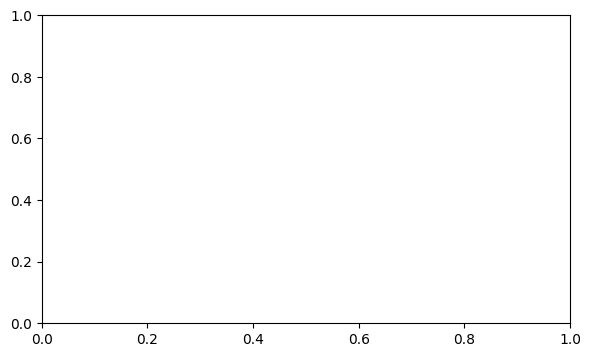

In [29]:
import matplotlib.pyplot as plt
EPOCHS = 20
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

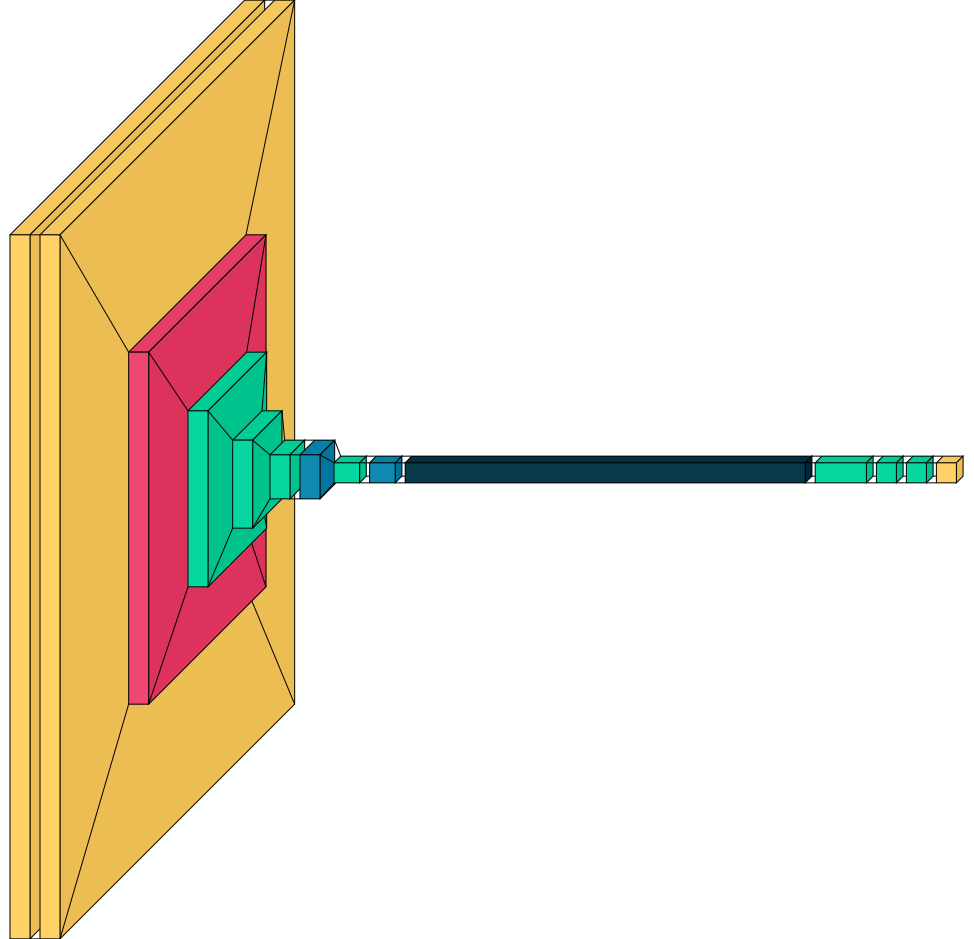

In [79]:
import visualkeras
visualkeras.layered_view(model).show() # display using your system viewer
visualkeras.layered_view(model, to_file='output.png') # write to disk
visualkeras.layered_view(model, to_file='output.png').show() # write and show

visualkeras.layered_view(model)